In [1]:
!pip install tslearn -q
!pip install --upgrade pandas -q
!pip install seaborn -q

In [2]:
import numpy as np
import pandas as pd

import string
import random
import scipy

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from tqdm.notebook import tqdm


from tslearn.generators import random_walks
from itertools import cycle

import gc

In [ ]:
# car_info_fs.columns

# Группируем признаки (фичи)

In [1]:
features2drop = [] 
targets = ['crop']  #
cat_features = [] 

filtered_features = [i for i in df.columns if (i not in targets and i not in features2drop)] #+ cat_features 
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features', cat_features)
print('num_features', len(num_features))
print('targets', targets)

for c in cat_features:
    df[c] = df[c].astype(str)

NameError: name 'df' is not defined

# Catboost Classifier

In [ ]:
from sklearn.model_selection import train_test_split


random_state = 42
n_splits = 3 # kfolds
print('num folds', n_splits)
clfs = []
targets = ['target_2']

# параметры валидации, обучение будет идти на n_splits фолдах

kFold_random_state = [42] # 666, 228, 777, 2021, 75]
N = len(kFold_random_state)*n_splits
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

X = car_info_fs[filtered_features].drop(targets, axis=1, errors='ignore')
y = car_info_fs[targets]#.copy()

X, test_data, y, y_data = train_test_split(X, y, stratify=y.values, test_size=0.45, random_state = 7575)
scores = []
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

    print(X_train.shape, y_train.shape)
    clf = CatBoostClassifier(iterations = 3500,
                          custom_metric =['Recall', 'AUC', 'Accuracy'],
                          loss_function='MultiClass', # MultiLogloss
                          # eval_metric = 'Precision', # F1:macro', #'AUC:hints=skip_train~false',
                          cat_features = cat_features,
                          random_seed=42,                          
#                           'learning_rate': 0.05953207713558619,
                          colsample_bylevel =  0.09874152157026818,
                          subsample = 0.9563761143682146,
#                           l2_leaf_reg = 9.178962968420354,
                             
                          min_data_in_leaf = 243,
                          bootstrap_type='Bernoulli',
                          ignored_features = ignored_features,
                          max_bin = 187,
                          task_type='CPU',
                          #auto_class_weights = 'SqrtBalanced',
                          early_stopping_rounds = 5)

    clfs.append(clf)

    clf.fit(train_dataset, eval_set=eval_dataset,
            verbose = False, use_best_model = True, plot = False)

    # scores.append(clf.best_score_['validation']['MultiClass'])
    scores.append(np.mean([v for k, v in clf.best_score_['validation'].items() if 'Recall' in k], dtype = 'float16'))
    clf.save_model("./tmp_data/cool_catboost_model_{}_deep".format(n))

assert len(clfs) == N
print('\n', 'score --------->', np.mean(scores, dtype = 'float16'), np.std(scores, dtype = 'float16'))


# инференс модели
y_pred = np.zeros((test_data.shape[0], 9)) # массив для записи финального результата
scores = []
for n, clf in enumerate(clfs):
    y_pred += clf.predict_proba(test_data[filtered_features])#[:,1]
    scores.append(clf.best_score_['validation']['Accuracy'])
#     clf.save_model("./tmp_data/cool_catboost_model_{}_deep".format(n))

y_pred /= N
y_pred = y_pred.argmax(axis=1)
acc_score = np.mean(y_pred == y_data[targets].values.reshape(1, -1)[0], dtype = 'float16')
print('', 'auc score', acc_score, 'vs', np.mean(scores, dtype = 'float16'), np.std(scores, dtype = 'float16'),'\n')


clf.save_model("./tmp_data/cool_catboost_model_kfold_{}".format(hash(train_index)))


In [297]:
# car_info_fs
car_info[car_info['car_id'].isin(car_info_fs.loc[test_data.index]['car_id'])].to_csv('../data/test_data.csv', index=False)
car_info[~car_info['car_id'].isin(car_info_fs.loc[test_data.index]['car_id'])].to_csv('../data/train_data.csv', index=False)

In [225]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# def chect_test(X_test, y_test, clfs):
#     # массив для записи финального результата
#     y_pred = np.zeros((X_test.shape[0], 7))
#     scores = {'MultiClass':[], 'Precision' : [], 'Recall' : []}
#     for n, clf in enumerate(clfs):
#         y_pred += clf.predict_proba(X_test[filtered_features])#[:,1]
#         scores['MultiClass'].append(clf.best_score_['validation']['MultiClass'])

#     y_pred =  np.argmax(y_pred, axis=1)

#     cm = confusion_matrix(y_test['target_2'], y_pred, normalize='all')
#     cmd = ConfusionMatrixDisplay(cm) #, display_labels=sorted(y_test['crop'].unique().tolist())
#     cmd.plot(xticks_rotation=45, cmap = 'viridis_r');

# chect_test(X_test, y_test, clfs[-1:])
y_test['target_2'].shape#.value_counts()
y_pred.shape

(1913,)

Всего признаков 68 Усреднее по 3-ти моделям: 
На график нанесено топ-100 признаков


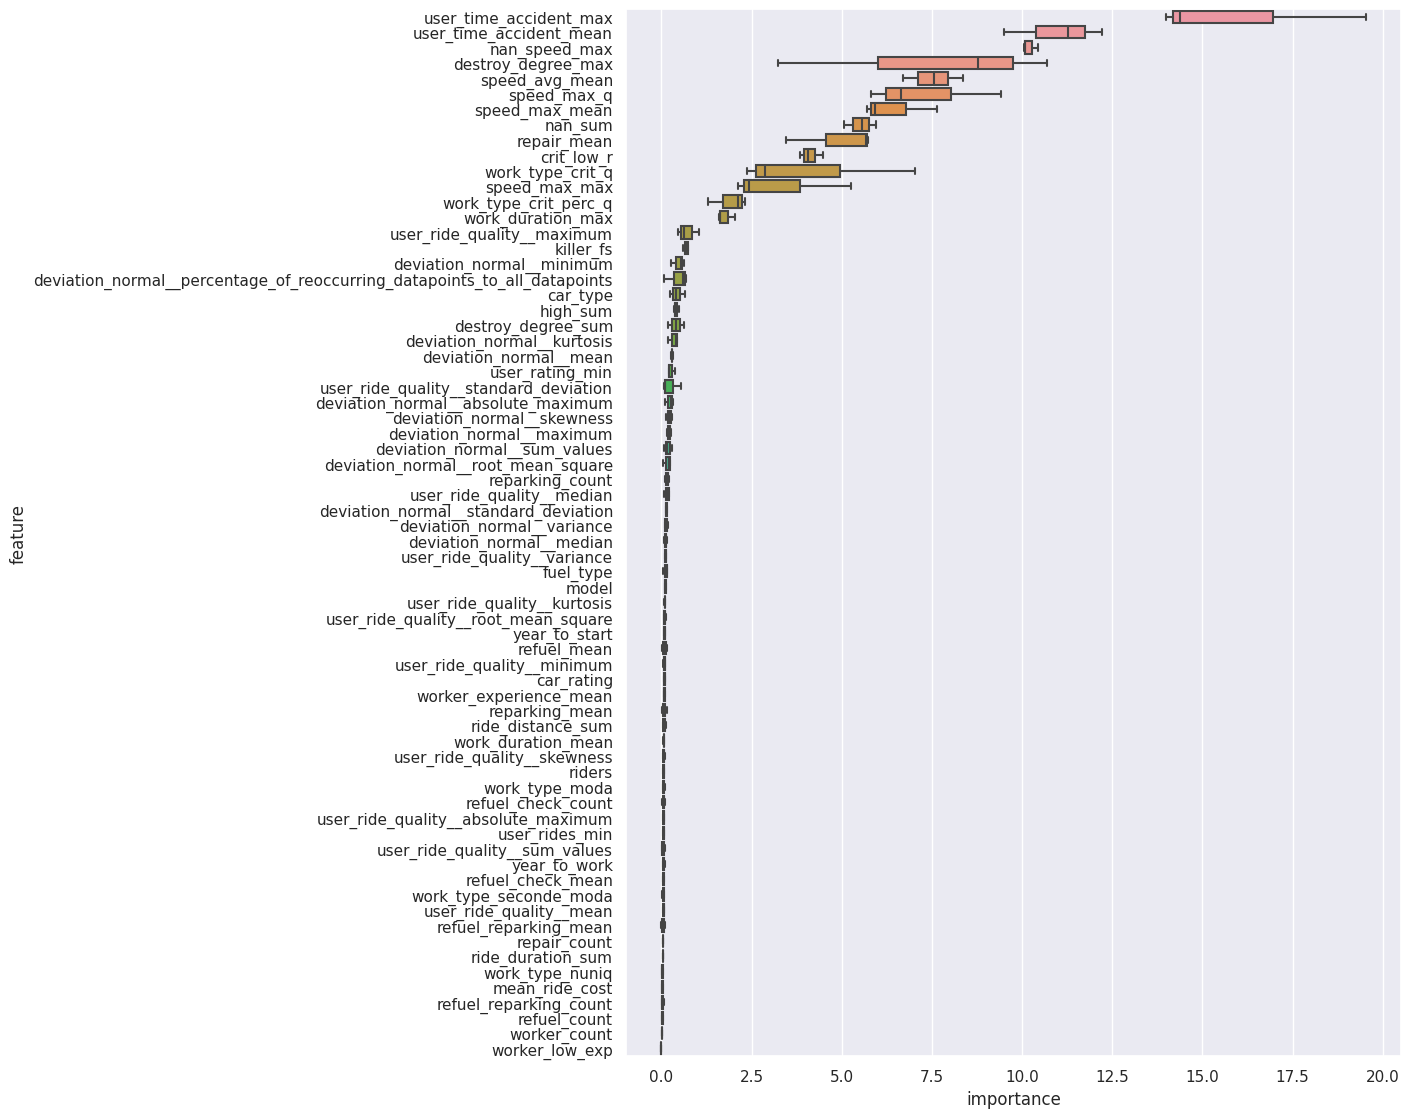

In [226]:
def plot_importance(df, best_model, height, top_n=50):
    
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков {} Усреднее по {}-ти моделям: '.format(len(cols_ord), len(best_model)) )
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    
    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

df_feats_imp = plot_importance(car_info_fs[filtered_features].drop(targets, axis=1, errors='ignore'), clfs[-
                                                                                                           3:], 0.20, top_n=100)


In [227]:
!pip install catboost -q
!pip uninstall opencv-python -y -q
!pip install opencv-python -q

In [228]:
!pip install shap -q

In [229]:
# import catboost
# from catboost import *

import shap

shap.initjs()

iteritems is deprecated and will be removed in a future version. Use .items instead.


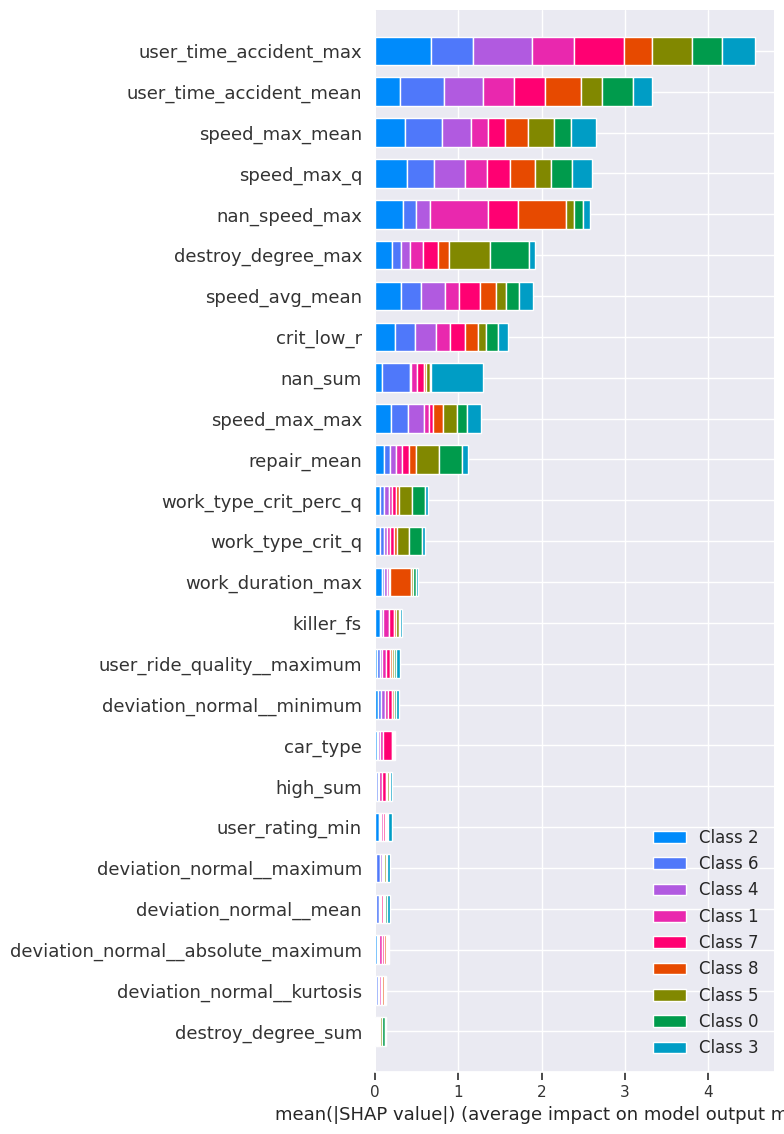

In [230]:
explainer = shap.TreeExplainer(clfs[-1])


train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
shap_values = explainer.shap_values(train_dataset)
# shap_values

# shap.dependence_plot("RM", shap_values, X)

shap.summary_plot(shap_values, X_train, max_display = 25)

In [231]:
from catboost.utils import get_confusion_matrix
import seaborn
# from sklearn.metrics import confusion_matrix


train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
confusion_matrix = get_confusion_matrix(clf, train_dataset, thread_count=-1)

In [232]:
target_dict  = {'engine_ignition' : 0,
    'another_bug' : 1,
    'engine_overheat' : 2,
    'gear_stick' : 3,
    'engine_fuel' : 4,
    'engine_check' : 5,
    'break_bug' : 6,
    'wheel_shake' : 7,
    'electro_bug' : 8}

# target_dict = {v:k for k, v in target_dict.items()}

f = lambda x: target_dict.get(x, x)

# car_info_fs['target_2'] = car_info_fs['target_2'].apply(f)

y_test['target_2'] = y_test['target_2'].apply(f)
y_test.value_counts()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


target_2
1           101
4            94
2            92
6            91
0            88
3            88
8            88
5            80
7            57
dtype: int64

In [233]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cm = confusion_matrix(y_test, cbc_pred, normalize='all')
# cmd = ConfusionMatrixDisplay(cm, display_labels=target_dict.keys())
# cmd.plot(xticks_rotation='45', cmap = 'viridis_r');


In [234]:
!pip install pandas_ml >> None

In [235]:
# from pandas_ml import ConfusionMatrix
# import matplotlib.pyplot as plt

# cm = ConfusionMatrix(y_test, y_pred)
# cmd.plot()

In [236]:
y_test['target_2'].value_counts()

1    101
4     94
2     92
6     91
0     88
3     88
8     88
5     80
7     57
Name: target_2, dtype: int64

# Catboost Regressor

In [237]:
# print(huge_train_final.columns)
# huge_train_final = huge_train_final

random_state = 42
n_splits = 3 # kfolds
print('num folds', n_splits)
clfs = []

targets = ['target_2']
X = car_info_fs[filtered_features].drop(targets, axis=1, errors='ignore')#.copy()
y = car_info_fs[targets]#.copy()

# параметры валидации, обучение будет идти на 6 X n_splits фолдах

kFold_random_state = [42]# , 666, 228, 777, 2021, 75]
N = len(kFold_random_state)*n_splits

kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

best_fs = ['ride_distance_sum','destroy_degree_sum','destroy_degree_max','riders','worker_experience_mean',
    'worker_low_exp','work_duration_mean','destroy_degree_max','work_type_crit_q','killer_fs',
    'repair_count','refuel_check_count','repair_mean','repair_mean','work_duration_max',
    'work_type_nuniq','user_time_accident_max','user_rating_min','user_rides_min']

# # Тренд взависимости от Таргета
# C = 1 # (2 - x.real_slope)*(2 + (x['deviation_normal__linear_trend__attr_"slope"'])**2)
ignored_features = ['car_rating', 'main_city', 'riders']
ignored_features_dict = {}
for num_i, fs in enumerate(best_fs):
    ignored_features+=[fs]
    scores = []
    for train_index, test_index in kf.split(X):

        # X_train, X_test = X[X.kfold!=kfold].drop('kfold', axis=1), X[X.kfold==kfold].drop('kfold', axis=1)
        # y_train, y_test = y[y.kfold!=kfold].drop('kfold', axis=1), y[y.kfold==kfold].drop('kfold', axis=1)

        X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
        eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

        print(X_train.shape, y_train.shape)
        clf = CatBoostRegressor(iterations = 30_000,
                              loss_function = 'MAE',
                              eval_metric = 'MAPE', #'AUC:hints=skip_train~false',
    #                           class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                              cat_features = cat_features,
                              random_seed=42,                          
    #                           'learning_rate': 0.05953207713558619,
                              colsample_bylevel =  0.09874152157026818,
                              subsample = 0.9563761143682146,
    #                           l2_leaf_reg = 9.178962968420354,
                              min_data_in_leaf = 243,
                              max_bin = 187,
                              ignored_features = ignored_features,
                              task_type='CPU', #auto_class_weights = 'SqrtBalanced',
                              early_stopping_rounds=100)# + kfold*10 )


        clfs.append(clf)

        # clf.fit(X_train, y_train, eval_set=(X_test, y_test),
        clf.fit(train_dataset, eval_set=eval_dataset,
                verbose = False, use_best_model = True, plot = False)
        scores.append(clf.best_score_['validation']['MAPE'])
        # scores.append(np.mean([v for k, v in clfs[0].best_score_['validation'].items() if 'Recall' in k]))
        print('score', scores[-1])
    
    print('------------', np.mean(scores))
    ignored_features_dict[num_i] = np.mean(scores)
    
#     clf.save_model("./tmp_data/cool_catboost_model_kfold_{}".format(hash(train_index)))
        
        
# assert len(clfs) == N

# массив для записи финального результата
# y_pred = np.zeros((test_data.shape[0], 10))
scores = []
for n, clf in enumerate(clfs):
    # y_pred += clf.predict_proba(test_data[filtered_features])#[:,1]
    scores.append(clf.best_score_['validation']['MAPE'])
#     clf.save_model("./tmp_data/cool_catboost_model_{}_deep".format(n))

# y_pred /= N
print('mean MultiLogloss', np.mean(scores))

num folds 3
(2833, 68) (2833, 1)


iteritems is deprecated and will be removed in a future version. Use .items instead.


CatBoostError: catboost/libs/data/feature_names_converter.h:28: String main_city is not a feature name

In [ ]:
# [v for k, v in clfs[0].best_score_['validation'].items() if 'Recall' in k]
clfs[0].best_score_['validation']

# Catboost Regressor

In [ ]:
# # print(huge_train_final.columns)
# # huge_train_final = huge_train_final

# random_state = 42
# n_splits = 3 # kfolds
# print('n_fold', n_splits)
# clfs = []

# targets = targets

# X = car_info_fs[filtered_features].fillna(0)#.copy()
# y = car_info_fs[['target_1']].fillna(car_info_fs['target_1'].mean())#.copy()

# # параметры валидации, обучение будет идти на 6 X n_splits фолдах

# kFold_random_state = [42]# , 666, 228, 777, 2021, 75]
# N = len(kFold_random_state)*n_splits

# kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# for train_index, test_index in kf.split(X):
        
# #     X_train, X_test = X[X.kfold!=kfold].drop('kfold', axis=1), X[X.kfold==kfold].drop('kfold', axis=1)
# #     y_train, y_test = y[y.kfold!=kfold].drop('kfold', axis=1), y[y.kfold==kfold].drop('kfold', axis=1)

#     X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
# #     train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
# #     eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
    
#     print(X_train.shape, y_train.shape)
#     clf = CatBoostRegressor(iterations = 30_000,
#                           loss_function = 'MAE',
#                           eval_metric = 'MAPE', #'AUC:hints=skip_train~false',
# #                           class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
#                           cat_features = cat_features,
#                           random_seed=42,                          
# #                           'learning_rate': 0.05953207713558619,
#                           colsample_bylevel =  0.09874152157026818,
#                           subsample = 0.9563761143682146,
# #                           l2_leaf_reg = 9.178962968420354,
#                           min_data_in_leaf = 243,
#                           max_bin = 187,
#                           task_type='CPU', #auto_class_weights = 'SqrtBalanced',
#                           early_stopping_rounds=2180)# + kfold*10 )
    
#     clfs.append(clf)

#     clf.fit(X_train, y_train, eval_set=(X_test, y_test),
# #     clf.fit(train_dataset, eval_set=eval_dataset,
#             verbose = 500, use_best_model = True, plot = False)
# #     clf.save_model("./tmp_data/cool_catboost_model_kfold_{}".format(hash(train_index)))
        
        
# assert len(clfs) == N

# # массив для записи финального результата
# # y_pred = np.zeros((test_data.shape[0], 10))
# scores = []
# for n, clf in enumerate(clfs):
#     # y_pred += clf.predict_proba(test_data[filtered_features])#[:,1]
#     scores.append(clf.best_score_['validation']['MAE'])
# #     clf.save_model("./tmp_data/cool_catboost_model_{}_deep".format(n))

# # y_pred /= N
# print('mean MAE', np.mean(scores))

In [ ]:
# clf.best_score_['validation']

# Feature Importance

In [ ]:
def plot_importance(df, best_model, height, top_n=50):
    
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков', len(cols_ord), 'Усреднее по {}-ти моделям: '.format(len(best_model)) )
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    
    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

df_feats_imp = plot_importance(car_info_fs[filtered_features], clfs[3:6], height = 0.20, top_n = 70)


In [ ]:
explainer = shap.TreeExplainer(clfs[2])


train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
shap_values = explainer.shap_values(train_dataset)
# shap_values

# shap.dependence_plot("RM", shap_values, X)

shap.summary_plot(shap_values, X_train)

In [ ]:
# plt.figure(figsize = (20, 20));
shap.dependence_plot("riders", shap_values, X_train)


# Смотрим на остатки

In [ ]:
cbr_prediction = clfs[0].predict(X_test)

df_pred = pd.DataFrame(cbr_prediction, columns = ["Predicted values"])
df_pred["Actual values"] =  y_test['target_1'].values

sns.relplot(data = df_pred, aspect = 4, kind = 'line')

In [ ]:
df_pred['diff'] = df_pred["Actual values"] - df_pred["Predicted values"]

sns.relplot(data = df_pred['diff'], aspect = 4, kind = 'line')

In [ ]:
# sns.realplot(data = X[])


# Тест на логику и гипотезы из таблицы

In [ ]:
target_dict  = {'engine_ignition' : 0,
    'another_bug' : 1,
    'engine_overheat' : 2,
    'gear_stick' : 3,
    'engine_fuel' : 4,
    'engine_check' : 5,
    'break_bug' : 6,
    'wheel_shake' : 7,
    'electro_bug' : 8}

target_dict = {v:k for k, v in target_dict.items()}

f = lambda x: target_dict.get(x, x)
car_info_fs['target_2'] = car_info_fs['target_2'].apply(f)

In [ ]:
# sns.set()
plt.figure(figsize = (20, 6))
sns.histplot(data = car_info_fs, hue = 'target_2', x = 'target_1', bins=50);

In [ ]:
sns.displot(data = car_info_fs, x = 'target_2', y = 'target_1', bins=50,
            aspect=5, height=10);

In [ ]:
car_info_fs

In [ ]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=n_clusters, random_state=42, max_iter=500)
cluster_labels = clusterer.fit_predict(X_embedded)

In [ ]:
Снизить разерность датасета, используя метод t-SNE

In [ ]:
from sklearn.manifold import TSNE


# Вспомогатльеные фрагменты кода
# data_x_y = TSNE(n_components=2, learning_rate='auto',
#                 random_state=22, n_jobs=-1, 
#                 init='random').fit_transform(df)

In [ ]:

#Вспомогатльеные фрагменты кода
# plt.figure(figsize=(12,9))
# plt.scatter(data_x, data_y, c=cluster_labels, cmap ='Set3', s=5)
# plt.scatter(data_x, data_y, c=y_blobs, s=1, cmap ='Set3')
# plt.legend(cluster_labels)
# plt.show()

In [ ]:
# TODO
- Догенерить базововую часть датасета
- Пошерить доступ на ноутбуки
- Гегерировать фичи уже при написании ноутбуков
- Утвердить программу 
- 

# Открываем файлы и смотрим, все ли в порядке

In [ ]:
# https://www.projectpro.io/recipes/upload-files-to-google-drive-using-python

# url = 'https://drive.google.com/file/d/1eqFIZCJTkXY-PsTeS-uz_DousIH3XQu-/view?usp=share_link'
# url = 'https://drive.google.com/file/d/1s_UlUxRszNn24R_cyfS9RWTNaJS2Z8DB/view?usp=share_link'
# url = 'https://drive.google.com/file/d/1eqFIZCJTkXY-PsTeS-uz_DousIH3XQu-/view?usp=share_link'
# url ='https://drive.google.com/uc?id=' + url.split('/')[-2]

url = 'https://drive.google.com/uc?id=1s_UlUxRszNn24R_cyfS9RWTNaJS2Z8DB'  # rides_info
rides_info = pd.read_csv(url)
rides_info.head().columns

# url = 'https://drive.google.com/uc?id=1eqFIZCJTkXY-PsTeS-uz_DousIH3XQu-'  # car_info
# car_info = pd.read_csv(url)
# car_info.head()

In [ ]:
import pandas as pd

# url = 'https://drive.google.com/file/d/1cGrFMilJtLrPPOTRfH46DX3qvBRnxdUT/view?usp=sharing'
# url ='https://drive.google.com/uc?id=' + url.split('/')[-2]
# url = 'https://drive.google.com/uc?id=1FkwxNT8_vN2pIYoFJx29l4ZhDYBzMamt' # rider_info - информация про водителей
# rider_info = pd.read_csv(url)
# rider_info.head()


In [ ]:
cols = ['car_id', 'model', 'car_type', 'fuel_type', 'car_rating', 'year_to_start', 'main_city', 'riders', 'year_to_work', 'target_1', 'target_2']
url = 'https://drive.google.com/uc?id=1s_UlUxRszNn24R_cyfS9RWTNaJS2Z8DB'
car_info = pd.read_csv(url)   # car_info - информация про машины с таргетом
car_info[cols]['target_2'].nunique()

In [ ]:
url = 'https://drive.google.com/uc?id=1eqFIZCJTkXY-PsTeS-uz_DousIH3XQu-'  
rides_info = pd.read_csv(url) # rides_info - информация про поездки
rides_info.drop(['car_rating','killer_fs'], axis=1).head(3)

In [ ]:
cols = ['user_id', 'age', 'sex', 'user_rating', 'user_rides', 'user_time_accident', 'first_ride_date']
url = 'https://drive.google.com/uc?id=1FkwxNT8_vN2pIYoFJx29l4ZhDYBzMamt' 
driver_info = pd.read_csv(url)  # driver_info - информация про водителей
driver_info[cols].head(3)

In [ ]:
cols = ['worker_id', 'car_id', 'work_type', 'destroy_degree', 'work_duration', 'fix_date']
url = 'https://drive.google.com/uc?id=1_UeE8KZmLb50phMoxcVT2hIdzToyVr42' # fix_info - информация про ремонт машин
fix_info = pd.read_csv(url)
fix_info[cols].head(3)

In [ ]:
# !pip install pydrive

In [ ]:
# gauth = GoogleAuth()           
# drive = GoogleDrive(gauth)  

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()           
drive = GoogleDrive(gauth) # 1hqEuNuaYdXV9D-j_Ctx0TndExJwoc23b

In [ ]:
upload_file_list = ['../data/fix_info.csv']
for upload_file in upload_file_list:
	gfile = drive.CreateFile({'parents': [{'id': '1hqEuNuaYdXV9D-j_Ctx0TndExJwoc23b'}]})
	# Read file and set it as the content of this instance.
	gfile.SetContentFile(upload_file)
	gfile.Upload() # Upload the file.

In [ ]:
!ls ../data/

In [ ]:
!conda install pycaret

In [ ]:
from pycaret.utils import version
version()